In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

# Problem definition

Cluster counties based on demographic and economic data

https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

# Load the data

In [2]:
#input
df = pd.read_csv('data/acs2015_county_data.csv')
df = df.set_index(['CensusId', 'State', 'County'])
df.head()

,,,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusId,State,County,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


# Feature Engineering 

In [3]:
# remove NaNs
df = df.dropna()

# remove column
X_columns = list(df.columns)
if 'IncomeErr' in X_columns:
    X_columns.remove('IncomeErr')
if 'IncomePerCapErr' in X_columns:
    X_columns.remove('IncomePerCapErr')
df = df[X_columns]

# normalize the columns
df_norm = df.copy()
for col in X_columns:
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

print(df.shape)
df_norm.head()

(3218, 32)


C:\Users\outpost\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,,,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusId,State,County,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,-0.138565,-0.141558,-0.135649,-0.436917,0.015217,0.688328,-0.182113,-0.085542,-0.182552,-0.142600,...,-0.759868,-0.186826,-0.891579,0.574999,-0.144510,-0.081324,0.519837,-0.621632,-0.633383,-0.120902
1003,Alabama,Baldwin,0.299519,0.296021,0.302818,-0.338162,0.333734,0.058063,-0.154533,-0.200496,-0.182552,0.378840,...,-0.624686,-0.126385,-0.229682,0.557128,0.269380,0.929400,-0.812026,-0.544978,0.245447,-0.145337
1005,Alabama,Barbour,-0.227149,-0.219720,-0.234253,-0.332964,-1.276304,2.663158,-0.209694,-0.315449,-0.182552,-0.240147,...,-0.408394,-0.065944,-0.954617,0.146099,-0.247296,-0.311616,0.504350,-0.161703,-0.413675,2.322651
1007,Alabama,Bibb,-0.240702,-0.235189,-0.245956,-0.457708,-0.041505,0.891413,-0.182113,-0.430402,-0.182552,-0.255838,...,-0.732831,-0.065944,-1.238287,0.986028,-0.249320,0.328083,-0.223528,-0.315013,0.245447,0.050147
1009,Alabama,Blount,-0.130771,-0.130282,-0.131211,-0.125057,0.543170,-0.502173,-0.195903,-0.430402,-0.182552,-0.134703,...,-0.651722,-0.730796,-0.733985,2.076149,-0.156513,0.993370,-0.626184,-0.953804,0.245447,-0.096466


# Model Training

In [4]:
k = 7
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2, 3, 4, 5, 6}
Counter({0: 1424, 3: 985, 1: 503, 2: 166, 6: 98, 5: 36, 4: 6})


[('Illinois', 87), ('Indiana', 87), ('Iowa', 85), ('Texas', 81), ('Ohio', 73)]
[('Nebraska', 59), ('Kansas', 55), ('Montana', 43), ('South Dakota', 42), ('Texas', 40)]
[('California', 17), ('New Jersey', 15), ('New York', 15), ('Texas', 10), ('Virginia', 10)]
[('Georgia', 116), ('Texas', 108), ('Mississippi', 73), ('Kentucky', 70), ('North Carolina', 58)]
[('California', 3), ('Arizona', 1), ('Illinois', 1), ('Texas', 1)]
[('Alaska', 13), ('South Dakota', 9), ('Montana', 4), ('North Dakota', 3), ('Arizona', 2)]
[('Puerto Rico', 78), ('Texas', 13), ('New Mexico', 4), ('Arizona', 1), ('California', 1)]
TotalPop


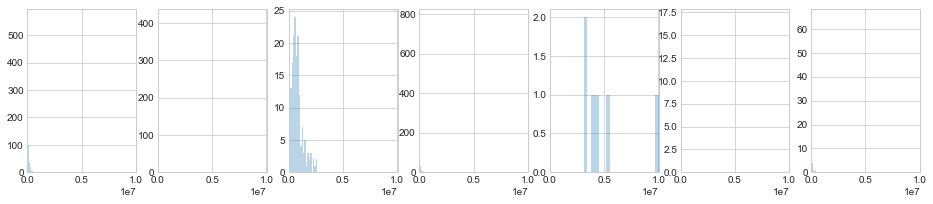

Men


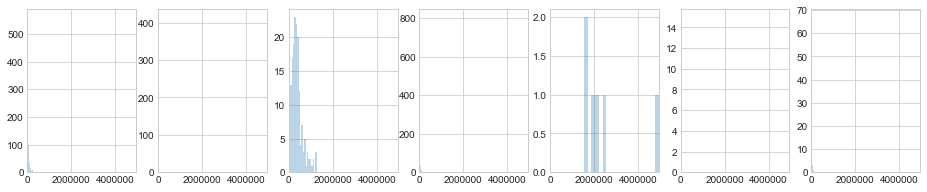

Women


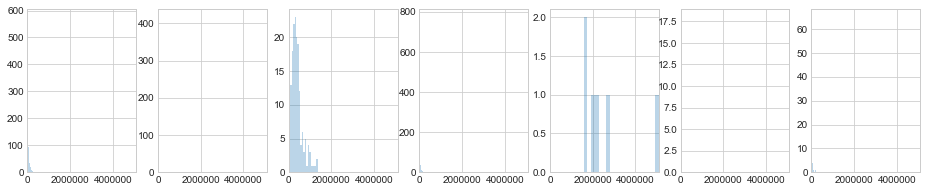

Hispanic


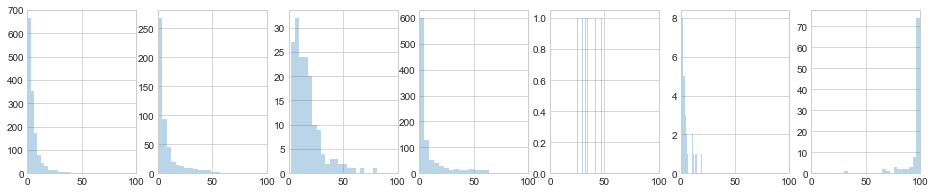

White


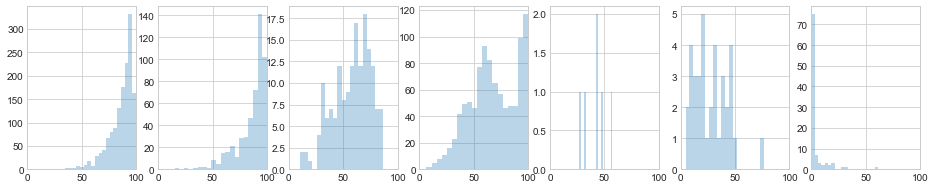

Black


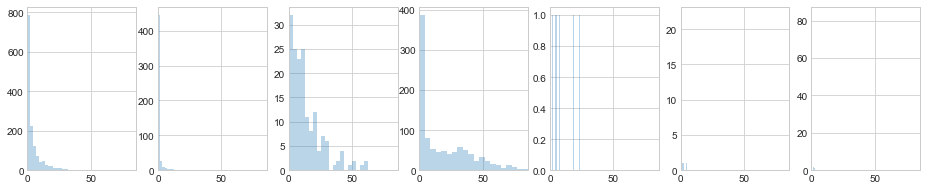

Native


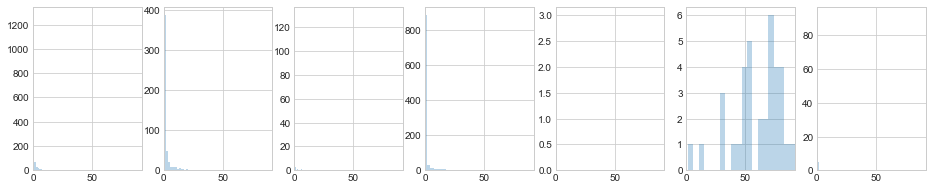

Asian


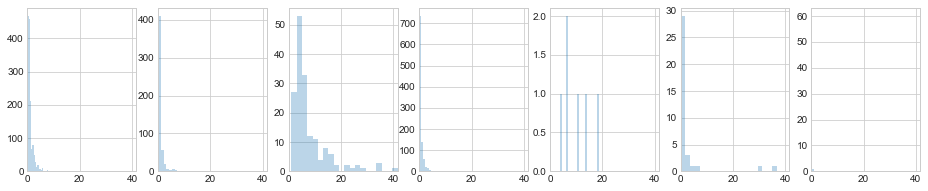

Pacific


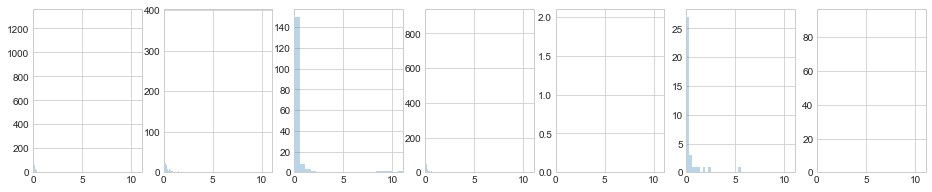

Citizen


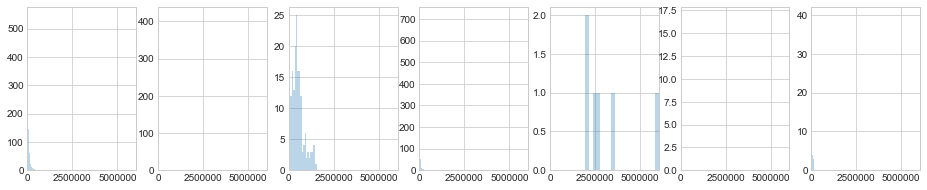

Income


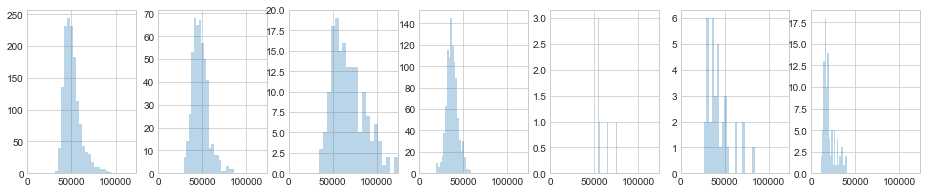

IncomePerCap


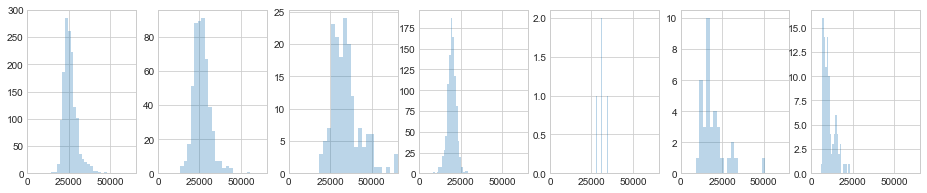

Poverty


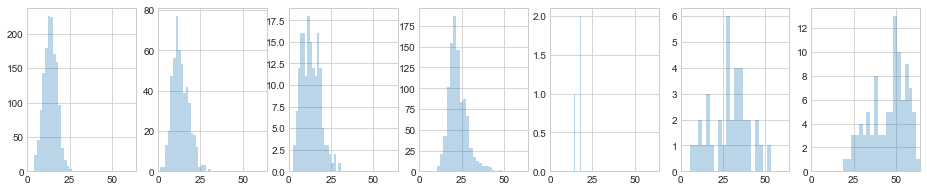

ChildPoverty


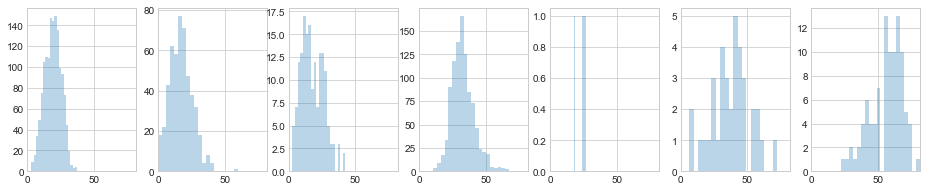

Professional


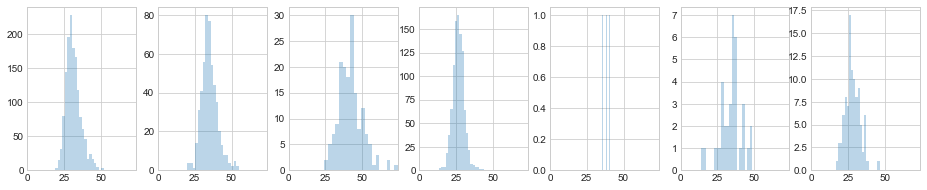

Service


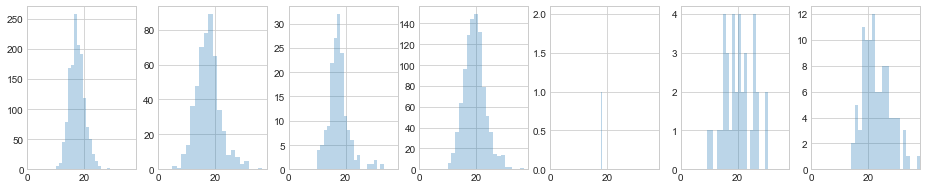

Office


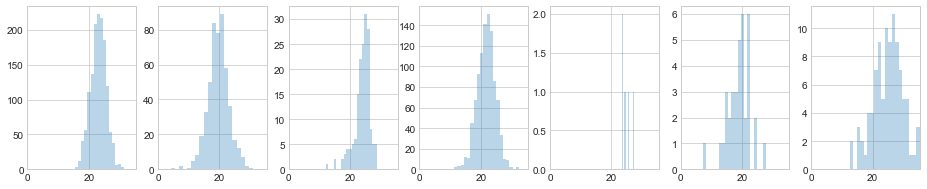

Construction


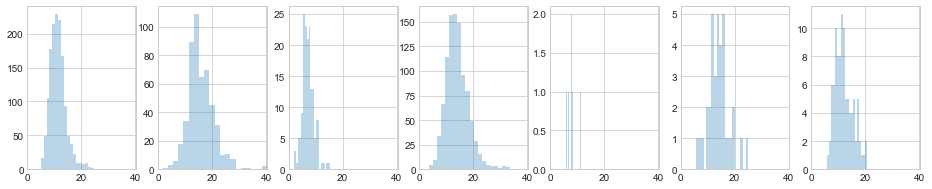

Production


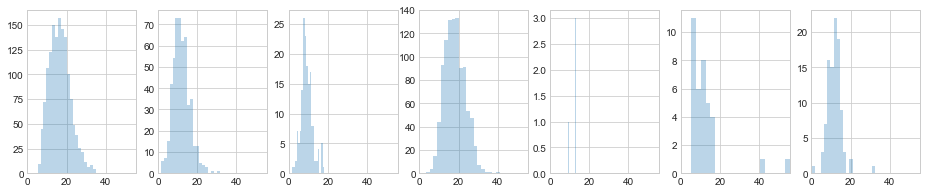

Drive


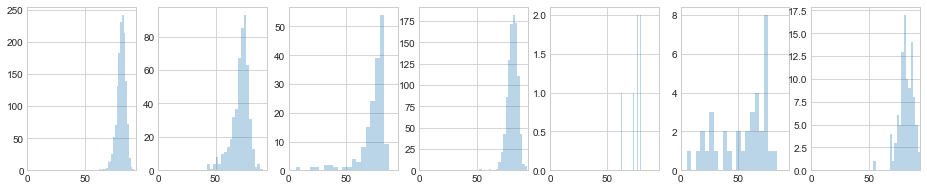

Carpool


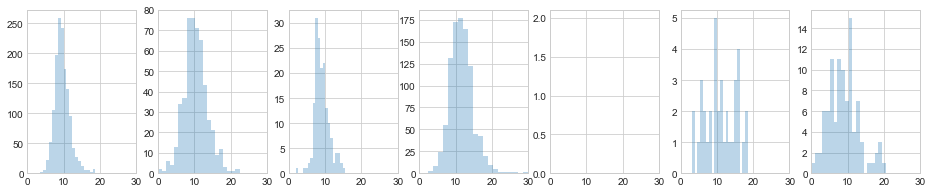

Transit


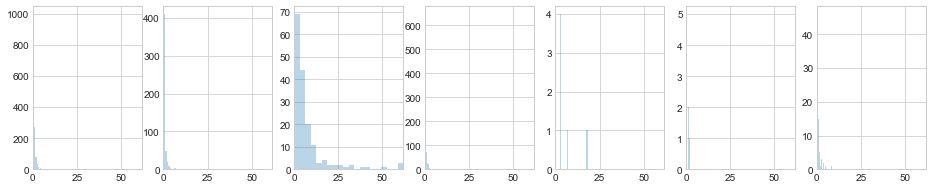

Walk


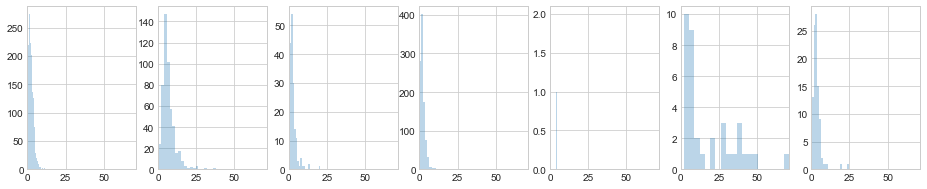

OtherTransp


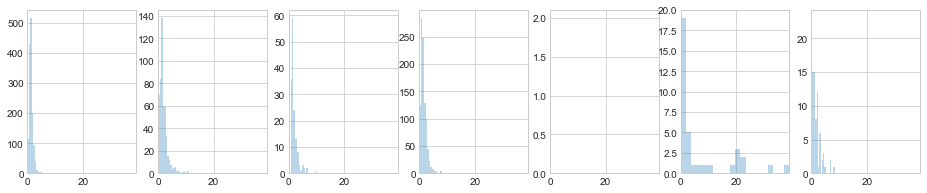

WorkAtHome


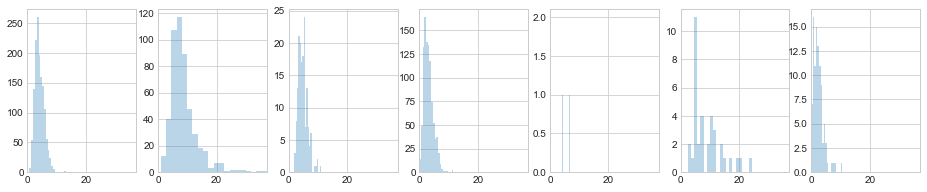

MeanCommute


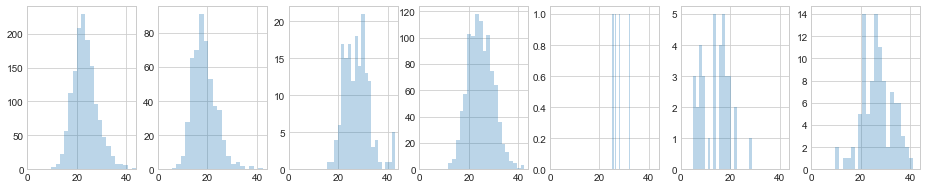

Employed


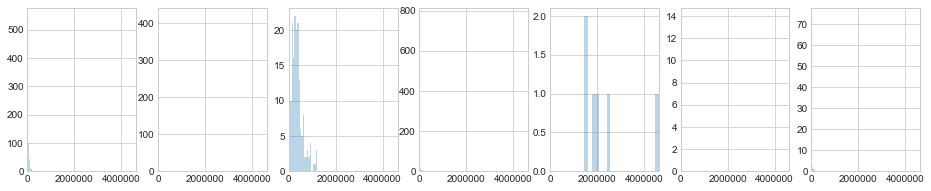

PrivateWork


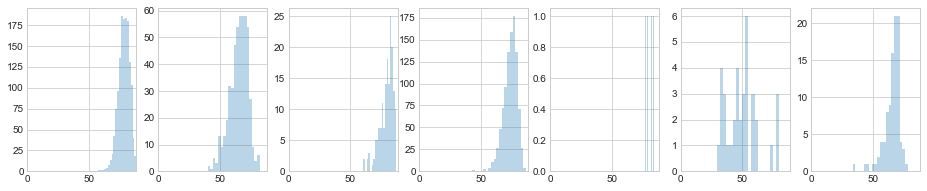

PublicWork


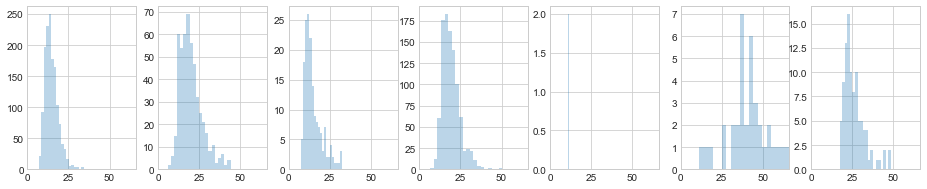

SelfEmployed


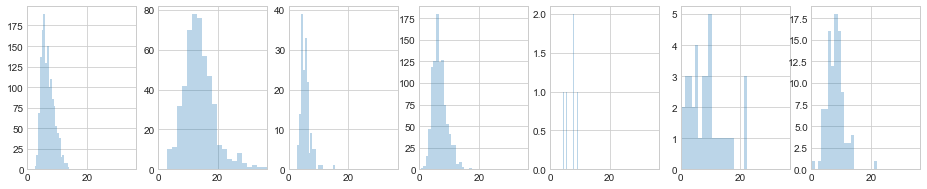

FamilyWork


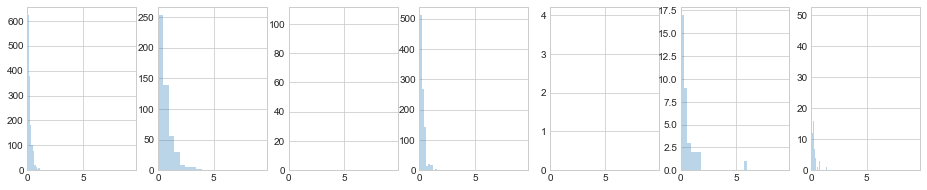

Unemployment


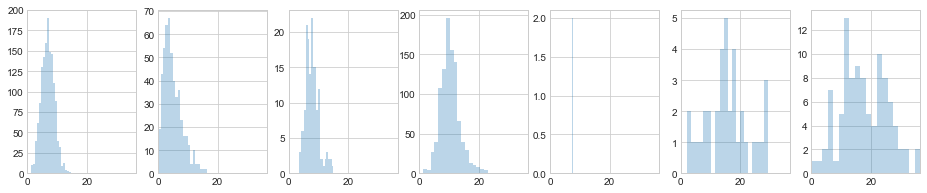

In [5]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['State']).most_common(5))

n_clusters = len(set(kmeans.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

In [6]:
# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5,6
CensusId,31738.94,31092.12,28339.08,28553.89,14569.00,23979.61,65387.42
TotalPop,77506.82,12034.17,788232.44,37121.85,4998075.17,13381.06,59114.47
Men,38234.95,6073.84,384972.12,18484.76,2465671.00,6749.64,28535.18
Women,39271.88,5960.32,403260.32,18637.09,2532404.17,6631.42,30579.29
Hispanic,6.00,8.46,16.80,10.26,35.28,4.25,95.54
White,85.88,85.76,57.86,67.17,41.40,27.87,3.67
Black,4.54,1.03,13.87,18.79,10.22,0.78,0.21
Native,0.68,2.11,0.35,1.30,0.45,59.48,0.20
Asian,1.04,0.74,7.61,0.66,10.15,2.79,0.15
Pacific,0.05,0.08,0.36,0.05,0.20,0.41,0.01


TotalPop


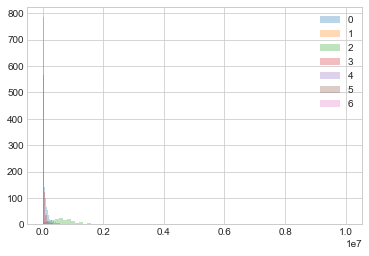

Men


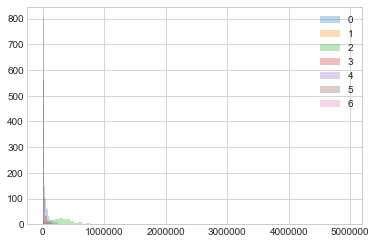

Women


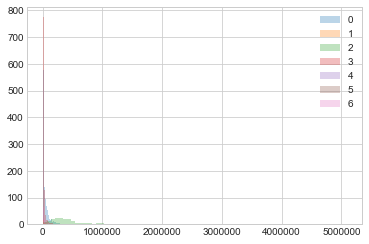

Hispanic


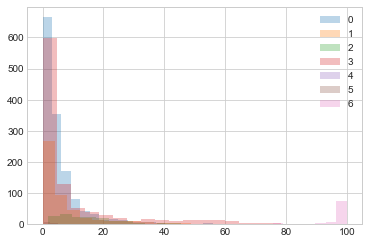

White


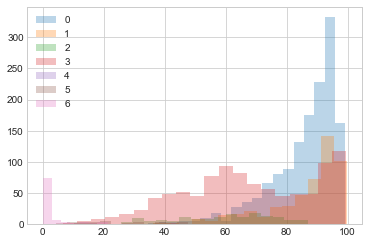

Black


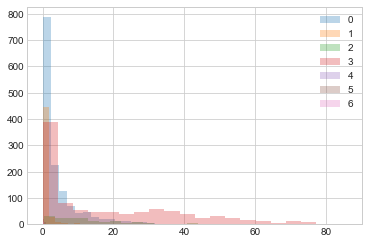

Native


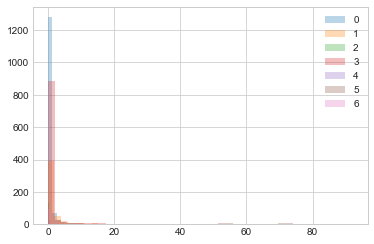

Asian


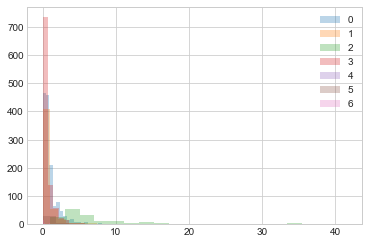

Pacific


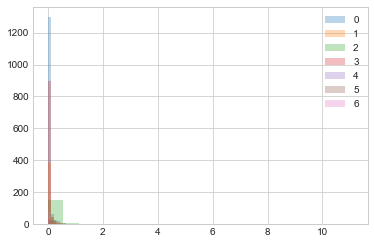

Citizen


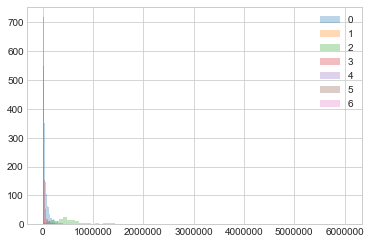

Income


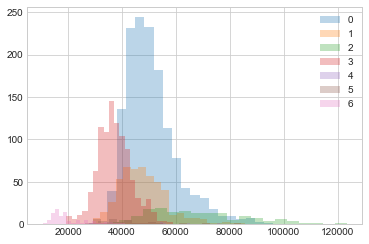

IncomePerCap


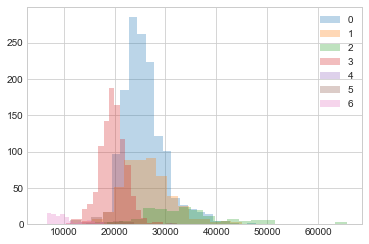

Poverty


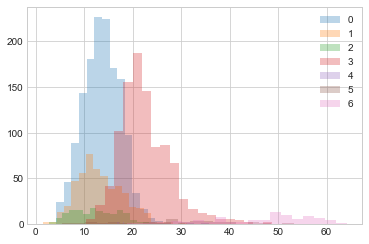

ChildPoverty


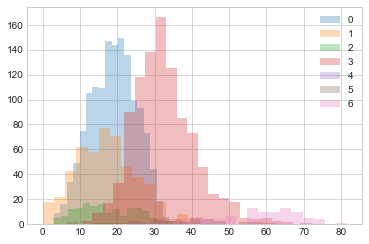

Professional


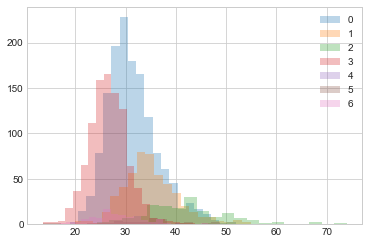

Service


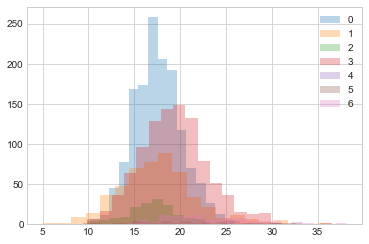

Office


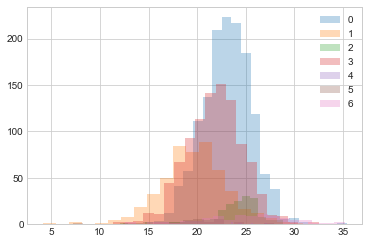

Construction


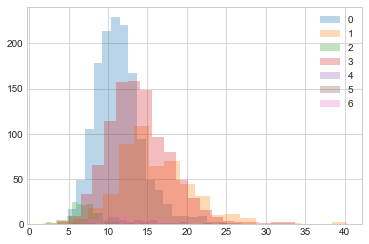

Production


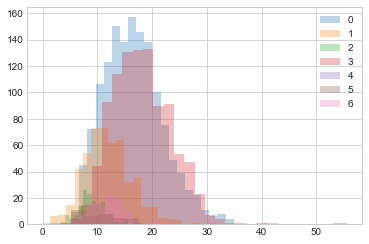

Drive


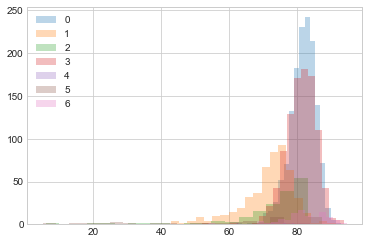

Carpool


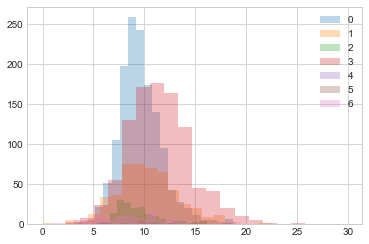

Transit


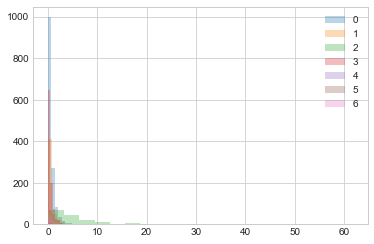

Walk


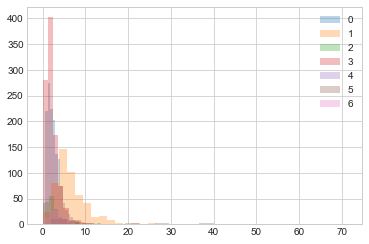

OtherTransp


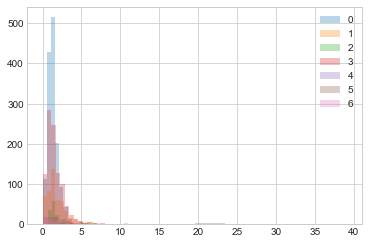

WorkAtHome


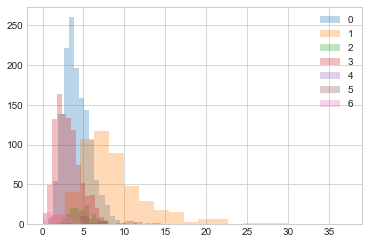

MeanCommute


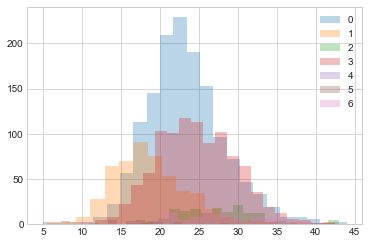

Employed


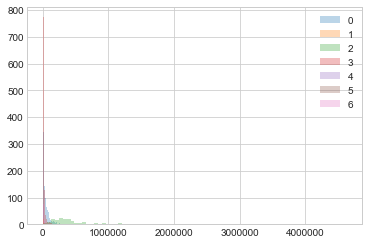

PrivateWork


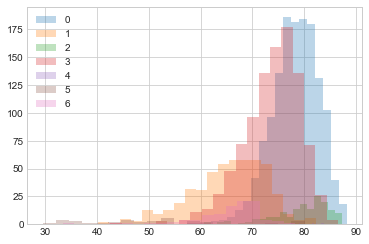

PublicWork


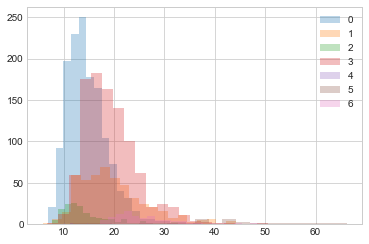

SelfEmployed


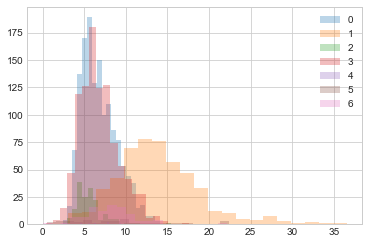

FamilyWork


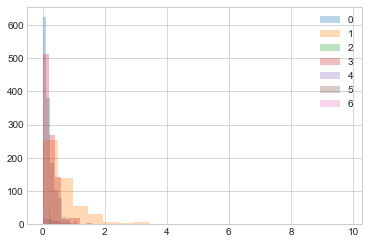

Unemployment


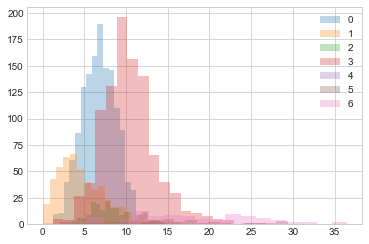

In [7]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

# Model Evaluation

In [8]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 4.230134814861171
Intra Cluster distance 0.20183276398782288
Inertia 60825.185671037936


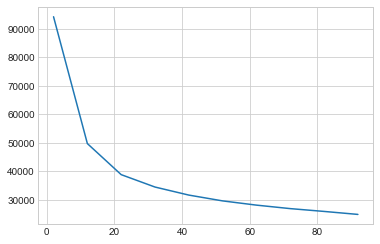

In [9]:
inertia = []
number_k = []
for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(df_norm.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()